In [1]:
import os
from typing import Tuple, Callable, Dict, Optional, List

import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs
from Recommenders.DataIO import DataIO
from skopt.space import Real, Integer, Categorical
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender,MultiThreadSLIM_SLIMElasticNetRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIM_S_ElasticNetRecommender
np.random.seed(2498)


columns_name = ['user_id','item_id','impression_list','data']

dataset_l = pd.read_csv('/Users/loren/Documents/GitHub/RecSys/dati/data_ICM_length.csv', sep=',')
dataset_t = pd.read_csv('/Users/loren/Documents/GitHub/RecSys/dati/data_ICM_type.csv', sep=',')
dataset = pd.read_csv('/Users/loren/Documents/GitHub/RecSys/dati/interactions_and_impressions.csv', sep=',')
test_users = pd.read_csv('/Users/loren/Documents/GitHub/RecSys/dati/data_target_users_test.csv',sep = ',')
dataset.columns = columns_name

c:\Users\loren\anaconda3\envs\RecSysFramework\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
#from kneed import KneeLocator
import scipy.sparse as sps


In [6]:
df_l = dataset_l.copy()
df_l.drop(columns = ['feature_id'], inplace = True)
df = dataset_l[dataset_l.item_id <= 24506]
data = df.data.values
dataPR = data.reshape(-1,1)
# kmeans = KMeans(n_clusters=7, random_state=0).fit(dataPR)
# df.data = kmeans.labels_.copy()
# num_items, min_item_id, max_item_id = len(df.data.unique()), df.data.min(), df.data.max()
# item = range(0,24506)
# df_1 = pd.get_dummies(df.data)
# column = range(num_items)
# df_1.columns = column
# df_1.index = df.item_id
# ICM_lenght = pd.DataFrame(np.zeros((24507,7)))
# ICM_lenght[ICM_lenght.index.isin(df_1.index)] = df_1
# sps.csr_matrix(ICM_lenght)

In [7]:
def preprocess(df):
    """Preprocess data for KMeans clustering"""
    
    df_log = np.log1p(df)
    scaler = StandardScaler()
    scaler.fit(df_log)
    df_norm = scaler.transform(df_log)
    
    return df_norm

In [16]:
def build_ICM_lengh_kmeans(dataset_l):
    df_l = dataset_l.copy()
    df_l.drop(columns = ['feature_id'], inplace = True)
    df = dataset_l[dataset_l.item_id <= 24506]
    data = df.data.values
    dataPR = data.reshape(-1,1)
    dataPR = preprocess(dataPR)
    n_clusters=3
    kmeans = KMeans(n_clusters, random_state=0).fit(dataPR)
    df.data = kmeans.labels_.copy()
    num_items, min_item_id, max_item_id = len(df.data.unique()), df.data.min(), df.data.max()
    item = range(0,24506)
    df_1 = pd.get_dummies(df.data)
    column = range(num_items)
    df_1.columns = column
    df_1.index = df.item_id
    ICM_lenght = pd.DataFrame(np.zeros((24507,n_clusters)))
    ICM_lenght[ICM_lenght.index.isin(df_1.index)] = df_1
    return sps.csr_matrix(ICM_lenght)

In [17]:
build_ICM_lengh_kmeans(dataset_l)

c:\Users\loren\anaconda3\envs\RecSysFramework\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<24507x3 sparse matrix of type '<class 'numpy.float64'>'
	with 19630 stored elements in Compressed Sparse Row format>

In [8]:
def elbow_plot(df):
    """Create elbow plot from normalized data"""
    
    df_norm = preprocess(df)
    
    sse = {}
    
    for k in range(1, 21):
        kmeans = KMeans(n_clusters=k, random_state=1)
        kmeans.fit(df_norm)
        sse[k] = kmeans.inertia_
    
    plt.title('Elbow plot for K selection')
    plt.xlabel('k')
    plt.ylabel('SSE')
    sns.pointplot(x=list(sse.keys()),
                 y=list(sse.values()))
    plt.show()

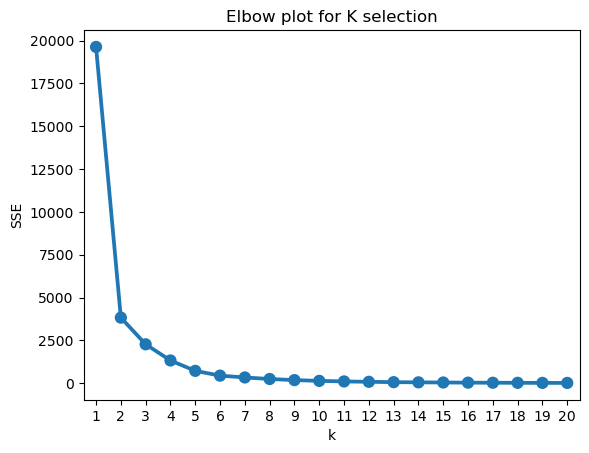

In [9]:
elbow_plot(dataPR)

In [12]:
from kneed import KneeLocator

def find_k(df, increment=0, decrement=0):
    """Find the optimum k clusters"""
    
    df_norm = preprocess(df)
    sse = {}
    
    for k in range(1, 21):
        kmeans = KMeans(n_clusters=k, random_state=1)
        kmeans.fit(df_norm)
        sse[k] = kmeans.inertia_
    
    kn = KneeLocator(x=list(sse.keys()), 
                 y=list(sse.values()), 
                 curve='convex', 
                 direction='decreasing')
    k = kn.knee + increment - decrement
    return k

In [13]:
find_k(dataPR)

3

In [ ]:
def run_kmeans(df, increment=0, decrement=0):
    """Run KMeans clustering, including the preprocessing of the data
    and the automatic selection of the optimum k. 
    """
    
    df_norm = preprocess(df)
    k = find_k(df, increment, decrement)
    kmeans = KMeans(n_clusters=k, 
                    random_state=1)
    kmeans.fit(df_norm)
    return df.assign(cluster=kmeans.labels_)

In [18]:
for i in range(0,0):
    print("cipolla")